In [2]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [3]:
lc = pd.read_parquet('data/lc2.parquet')
lc = lc.sort_values(['object_id', 'mjd'])
ids = np.unique(lc.object_id)
lc.head()

,object_id,passband,mjd,flux,flux_norm
0,1000183,0,59575.0,-2.349386,-0.059370
0,1000183,1,59575.0,0.945535,0.228296
0,1000183,2,59575.0,-0.223170,-0.452377
0,1000183,3,59575.0,3.940555,0.267860
0,1000183,4,59575.0,2.240180,-0.043889


In [4]:
# make labels
meta = pd.read_csv('data/plasticc_test_metadata.csv', compression="gzip")
meta.head(2)

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,13,34.4531,-5.2295,1,0.305,0.319,0.054,41.112,0.019,0,...,0.0,0.0,60499.461,124,0.0,0.0,0.0,0.0,0.0,0.0
1,14,33.3984,-4.3311,1,-9.000,0.632,0.018,42.877,0.018,0,...,0.0,0.0,59792.121,120,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# query labels
labels = meta['target'][meta.object_id.isin(ids)]

In [6]:
nsample = ids.shape[0]
data = lc.flux_norm.values.reshape(nsample, 72*6)

In [7]:
train_data, val_data, train_label, test_label = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle=True)

# Convert to PyTorch tensors
train_dataset = torch.FloatTensor(train_data)
val_dataset = torch.FloatTensor(val_data)

# Print shapes to verify
print(f"Training set shape: {train_dataset.shape}")
print(f"Validation set shape: {val_dataset.shape}")

print("Data preparation completed!")

Training set shape: torch.Size([276797, 432])
Validation set shape: torch.Size([69200, 432])
Data preparation completed!


In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()

        # Encoder and Decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 32),
            nn.GELU()
        )

        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_log_var = nn.Linear(32, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.GELU(),
            nn.Linear(32, 64),
            nn.GELU(),
            nn.Linear(64, 128),
            nn.GELU(),
            nn.Linear(128, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_log_var(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


# Hyperparameters
input_dim = 6*72  # 12 features * 6 bands
latent_dim = 32
batch_size = 128
num_epochs = 50
learning_rate = 1e-3
model = VAE(input_dim, latent_dim).to('mps')
# model.load_state_dict(torch.load('lsst_vae.pth'))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)


# Loss function
def loss_function(recon_x, x, mu, log_var, beta=1.0):
    MSE = nn.MSELoss()(recon_x, x)
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE + beta * KLD

# Prepare the data
train_loader = DataLoader(TensorDataset(train_dataset), batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(TensorDataset(val_dataset), batch_size=batch_size, pin_memory=True, num_workers=4, persistent_workers=True)

# Lists to store losses for plotting
train_losses = []
val_losses = []

# Define the max norm for gradient clipping
max_grad_norm = 1.0

In [9]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch in train_loader:
        inputs = batch[0].to('mps')
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(inputs)
        loss = loss_function(recon_batch, inputs, mu, log_var)
        loss.backward()

        clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

        train_loss += loss.item()
        optimizer.step()

    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to('mps')
            recon_batch, mu, log_var = model(inputs)
            loss = loss_function(recon_batch, inputs, mu, log_var)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    torch.save(model.state_dict(), 'lsst_vae_b2.pth')

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

Epoch [1/50], Train Loss: 0.9366, Val Loss: 0.8880
Epoch [2/50], Train Loss: 0.8814, Val Loss: 0.8800
Epoch [3/50], Train Loss: 0.8770, Val Loss: 0.8776
Epoch [4/50], Train Loss: 0.8750, Val Loss: 0.8755
Epoch [5/50], Train Loss: 0.8737, Val Loss: 0.8754
Epoch [6/50], Train Loss: 0.8730, Val Loss: 0.8742
Epoch [7/50], Train Loss: 0.8726, Val Loss: 0.8741
Epoch [8/50], Train Loss: 0.8719, Val Loss: 0.8737
Epoch [9/50], Train Loss: 0.8718, Val Loss: 0.8726
Epoch [10/50], Train Loss: 0.8713, Val Loss: 0.8728
Epoch [11/50], Train Loss: 0.8710, Val Loss: 0.8728
Epoch [12/50], Train Loss: 0.8708, Val Loss: 0.8724
Epoch [13/50], Train Loss: 0.8705, Val Loss: 0.8725
Epoch [14/50], Train Loss: 0.8703, Val Loss: 0.8716
Epoch [15/50], Train Loss: 0.8701, Val Loss: 0.8717
Epoch [16/50], Train Loss: 0.8701, Val Loss: 0.8710
Epoch [17/50], Train Loss: 0.8698, Val Loss: 0.8713
Epoch [18/50], Train Loss: 0.8697, Val Loss: 0.8715
Epoch [19/50], Train Loss: 0.8695, Val Loss: 0.8713
Epoch [20/50], Train 

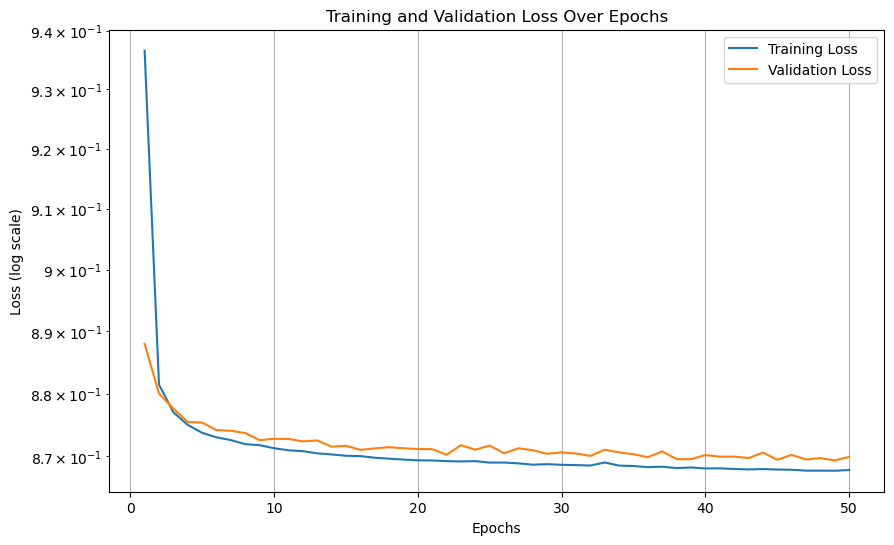

In [10]:
# Plotting function
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.yscale('log')  # Set y-axis to log scale
    plt.grid(True)
    # plt.savefig('../plots/vae_training_loss.png')

# Plot the losses
plot_losses(train_losses, val_losses)

In [12]:
# Using the trained model for encoding
def encode_data(model, data):
    model.eval()
    with torch.no_grad():
        mu, log_var = model.encode(data)
        z = model.reparameterize(mu, log_var)
    return z

# Load the trained model
loaded_model = VAE(input_dim, latent_dim)
loaded_model.load_state_dict(torch.load('lsst_vae_b2.pth'))

# Encode the test dataset
encoded_test = encode_data(loaded_model, val_dataset)

print("Shape of encoded test data:", encoded_test.shape)

Shape of encoded test data: torch.Size([69200, 32])


/var/folders/cy/5cqfjfyx7nn07hlr20tp3dkw0000gn/T/ipykernel_29275/114144329.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('lsst

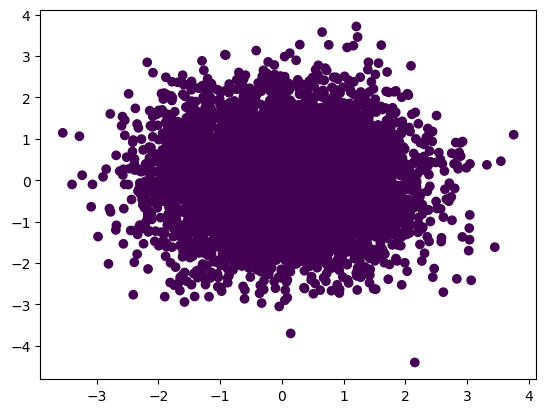

In [21]:
plt.scatter(encoded_test[:, 0], encoded_test[:, 2], c=test_label)

In [13]:
# Generate new samples
def generate_samples(model, num_samples):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        samples = model.decode(z)
    return samples

new_samples = generate_samples(loaded_model, 10)

In [14]:
t_fill = np.linspace(59572, 60684, 432)

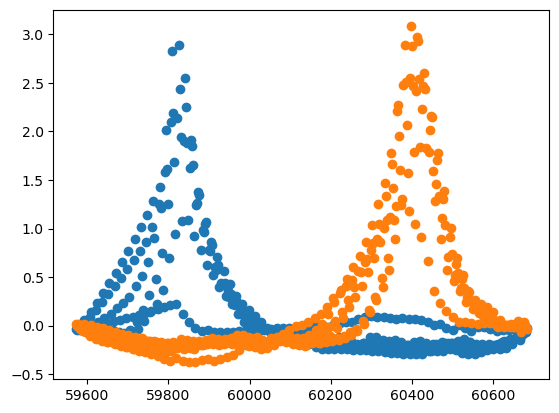

In [15]:
for i in range(new_samples.shape[0])[:2]:
    plt.scatter(t_fill, new_samples[i])

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_comp = pca.fit(encoded_test).transform(encoded_test)

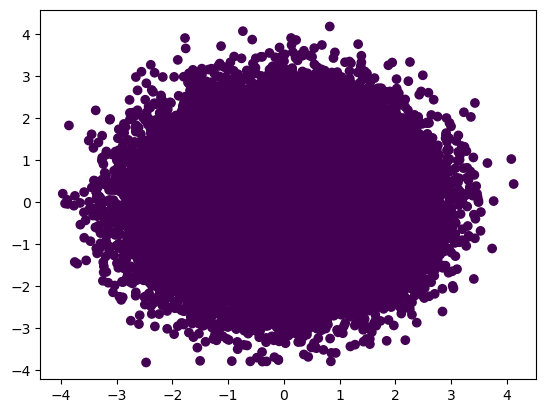

In [18]:
plt.scatter(pca_comp[:, 0], pca_comp[:,1], c=test_label>100)